# ロジスティック回帰とROC曲線

## サンプルデータ

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame
from numpy.random import rand, multivariate_normal

pd.options.mode.chained_assignment = None

In [2]:
Variances = [5, 10, 30, 50] # 両クラス共通の分散(4種類の分散で計算を実施)

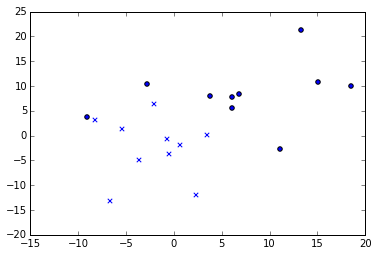

In [4]:
def prepare_dataset(variance):
    n1 = 10
    n2 = 10
    mu1 = [7, 7]
    mu2 = [-3, -3]
    cov1 = np.array([[variance, 0], [0, variance]])
    cov2 = np.array([[variance, 0], [0, variance]])
    
    df1 = DataFrame(multivariate_normal(mu1, cov1, n1), columns=['x', 'y'])
    df1['type'] = 1
    df2 = DataFrame(multivariate_normal(mu2, cov2, n2), columns=['x', 'y'])
    df2['type'] = 0
    df = pd.concat([df1, df2], ignore_index=True)
    df = df.reindex(np.random.permutation(df.index)).reset_index(drop=True)
    return df

set = prepare_dataset(Variances[3])
set1 = set[set['type'] == 1]
set2 = set[set['type'] == 0]
plt.scatter(set1.x, set1.y, marker='o')
plt.scatter(set2.x, set2.y, marker='x')

ロジスティック回帰を用いて上記データを分類する。ロジスティック回帰では、確率を用いた最尤推定法でパラメーターを決定する。最尤推定法では「あるデータが得られる確率」を設定しておき、そこから逆にトレーニングセットで与えられるデータが得られる確率(尤度関数)を計算して、尤度関数が最大となるという条件から、最初に設定した確率の式に含まれるパラメーターを決定する。

## 分類問題への最尤推定法の適用

### データの発生確率の設定

2種類のデータを分割する直線を表す線形関数$f(x, y)$を次式で定義する。

$$
f(x, y) = w_0 + w_1x + w_2y \tag{5.1}
$$

次に、$(x, y)$平面上の任意の点において、そこで得られるデータの属性が$t=1$である確率を考える。ここでは$f(x, y)$の値に対して、ロジスティック関数で得られる確率を対応させる。

$$
\sigma(a) = \frac{1}{1 + \mathrm{e} ^ {-a}} \tag{5.2}
$$

以上から点$(x, y)$で得られたデータの属性が$t=1$である確率は次式で表せる。

$$
P(x, y) = \sigma(w_0 + w_1x + w_2y) \tag{5.3}
$$

次に、トレーニングセットとして与えられたデータ$\left\{ (x_n, y_n, t_n) \right\}_{n=1}^N$が得られる確率を考える。まず、特定の一つのデータ$(x_n, y_n, t_n)$について考えると、そのようなデータが得られる確率は次式で表せる。

$$
\begin{align*}
t_n = 1の場合 &: P(x_n, y_n) \tag{5.4} \\
t_n = 0の場合 &: 1 - P(x_n, y_n) \tag{5.5}
\end{align*}
$$

これらはまとめて以下の式で表せる。

$$
P_n = P(x_n, y_n)^{t_n} \left\{ 1 - P(x_n, y_n) \right\} ^ {1 - t_n} \tag{5.6}
$$

(5.6)に(5.3)を代入すると以下式が得られる。

$$
P_n = z_n^{t_n}(1 - z_n) ^ {1 - t_n} \tag{5.9}
$$

ここで$z_n$は「n番目のデータの属性が$t=1$である確率」で次式で表せる。

$$
\begin{align*}
z_n &= \sigma(\mathbf{w}^\mathrm{T} \mathbf{\phi_n}) \tag{5.10} \\
\mathbf{w} &= \left(
    \begin{array}{c}
    w_0 \\
    w_1 \\
    w_2 \\
    \end{array}
\right) \tag{5.11} \\
\mathbf{\phi_n} &= \left(
    \begin{array}{c}
    1 \\
    x_n \\
    y_n \\
    \end{array}
\right) \tag{5.12}
\end{align*}
$$

最後に、トレーニングセットに含まれるデータが得られる確率は確率(5.9)の積になり次式で表せる。

$$
P = \prod_{n=1}^N P_n = \prod_{n=1}^N z_n^{t_n} (1 - z_n) ^ {1 - t_n} \tag{5.13}
$$

### 最尤推定法によるパラメーターの決定

(5.13)はトレーニングセットが得られる確率$P$をパラメーター$\mathbf{w}$の関数としてみたもので、尤度関数である。最尤推定法ではこの尤度関数を最大にする$\mathbf{w}$を決定する。そのためには、確率$P$の値が大きくなる方向に$\mathbf{w}$を修正する手順を繰り返すアルゴリズムを採用する。アルゴリズムとしては、「ニュートン・ラフソン法」を適用した以下を用いる(<font color="red">ニュートン・ラフソン法はまだ理解できてない</font>)。

$$
\mathbf{w_{new}} = \mathbf{w_{old}} - (\mathbf{\Phi} ^ \mathrm{T} \mathbf{R} \mathbf{\Phi}) ^ {-1} \mathbf{\Phi} ^ \mathrm{T} (\mathbf{z} - \mathbf{t}) \tag{5.14}
$$

$$
\begin{align*}
\mathbf{t} &= \left(
    \begin{array}{c}
    t_1 \\
    \vdots \\
    t_N
    \end{array}
\right) \tag{5.15} \\
\mathbf{\Phi} &= \left(
    \begin{array}{c}
    1 & x_1 & y_1 \\
    1 & x_2 & y_2 \\
    \vdots & \vdots & \vdots \\
    1 & x_N & y_N \\
    \end{array}
\right) \tag{5.16} \\
\mathbf{z} = &= \left(
    \begin{array}{c}
    z_1 \\
    \vdots \\
    z_N
    \end{array}
\right) \tag{5.17} \\
\mathbf{R} &= \mathrm{diag}[z_1(1 - z_1), \cdots, z_N(1 - z_N)] \tag{5.18}
\end{align*}
$$

ここで$\mathbf{t}$と$\mathbf{\Phi}$はトレーニングセットのデータから決まる定数のベクトル／行列、一方$\mathbf{z}$と$\mathbf{R}$に含まれる$z_n$はパラメーター$\mathbf{w}$に依存している。従って、パラメーター$\mathbf{w_{old}}$が与えられた際に、これを用いて$\mathbf{z}$と$\mathbf{R}$を計算して、これを(5.14)に代入することで新しい$\mathbf{w_{new}}$が求まる。これを繰り返すことで確立$P$を最大にする$\mathbf{w}$を求める。

この試行は、次式が成立した時点で計算を打ち切るようにする。

$$
\frac{\| \mathbf{w_{new}} - \mathbf{w_{old}} \| ^ 2}{\| \mathbf{w_{old}} \| ^ 2} < 0.001 \tag{5.19}
$$

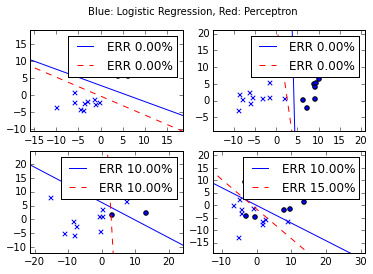

In [10]:
# ロジスティック回帰
def run_logistic(train_set, subplot):
    w = np.array([[0], [0.1], [0.1]])
    phi = train_set[['x', 'y']]
    phi['bias'] = 1
    phi = phi.as_matrix(columns=['bias', 'x', 'y'])
    t = train_set[['type']]
    t = t.as_matrix()
    
    # 最大30回のIterationを実施
    for i in range(30):
        # IRLS法によるパラメーターの修正
        y = np.array([])
        for line in phi:
            a = np.dot(line, w)
            y = np.append(y, [1.0 / (1.0 + np.exp(-a))])
        r = np.diag(y * (1 - y))
        y = y[np.newaxis,:].T
        tmp1 = np.linalg.inv(np.dot(np.dot(phi.T, r), phi))
        tmp2 = np.dot(phi.T, (y - t))
        w_new = w - np.dot(tmp1, tmp2)
        # パラメーターの変化が0.1%1未満になったら終了
        if np.dot((w_new - w).T, (w_new - w)) < 0.001 * np.dot(w.T, w):
            w = w_new
            break
        w = w_new
        
    # 分類誤差の計算
    w0, w1, w2 = w[0], w[1], w[2]
    err = 0
    for index, point in train_set.iterrows():
        x, y, type = point.x, point.y, point.type
        type = type * 2 - 1
        if type * (w0 + w1 * x + w2 * y) < 0:
            err += 1
    err_rate = err * 100 / len(train_set)
    
    # 結果を表示
    xmin, xmax = train_set.x.min() - 5, train_set.x.max() + 10
    linex = np.arange(xmin - 5, xmax + 5)
    liney = - linex * w1 / w2 - w0 / w2
    label = "ERR %.2f%%" % err_rate
    subplot.plot(linex, liney, label=label, color='b')
    subplot.legend(loc=1)

# パーセプトロン
def run_perceptron(train_set, subplot):
    w0 = w1 = w2 = 0.0
    bias = 0.5 * (train_set.x.mean() + train_set.y.mean())
    
    # Iterationを30回実施
    for i in range(30):
        # 確率的勾配降下法によるパラメーターの修正
        for index, point in train_set.iterrows():
            x, y, type = point.x, point.y, point.type
            type = type * 2 - 1
            if type * (w0 * bias + w1 * x + w2 * y) <= 0:
                w0 += type * 1
                w1 += type * x
                w2 += type * y
    # 分類誤差の計算
    err = 0
    for index, point in train_set.iterrows():
        x, y, type = point.x, point.y, point.type
        type = type * 2 - 1
        if type * (w0 * bias + w1 * x + w2 * y) <= 0:
            err += 1
    err_rate = err * 100 / len(train_set)
    
    # 結果を表示
    xmin, xmax = train_set.x.min() - 5, train_set.x.max() + 10
    linex = np.arange(xmin - 5, xmax + 5)
    liney = -linex * w1 / w2 - bias * w0 / w2
    label = "ERR %.2f%%" % err_rate
    subplot.plot(linex, liney, label=label, color='r', linestyle='--')
    subplot.legend(loc=1)

def run_simulation(variance, subplot):
    train_set = prepare_dataset(variance)
    train_set1 = train_set[train_set['type'] == 1]
    train_set2 = train_set[train_set['type'] == 0]
    ymin, ymax = train_set.y.min() - 5, train_set.y.max() + 10
    xmin, xmax = train_set.x.min() - 5, train_set.x.max() + 10
    subplot.set_ylim([ymin - 1, ymax + 1])
    subplot.set_xlim([xmin - 1, xmax + 1])
    subplot.scatter(train_set1.x, train_set1.y, marker='o')
    subplot.scatter(train_set2.x, train_set2.y, marker='x')
    
    run_logistic(train_set, subplot)
    run_perceptron(train_set, subplot)

fig = plt.figure()
plt.suptitle('Blue: Logistic Regression, Red: Perceptron')
for c, variance in enumerate(Variances):
    subplot = fig.add_subplot(2, 2, c + 1)
    run_simulation(variance, subplot)

ロジスティック回帰とパーセプトロンの分類結果を比較すると、ロジスティック回帰の優位性がわかる。これは、パーセプトロンの確率的勾配降下法では、一度すべてのデータが正しく分類されるとそこでパラメーターの変化が停止するため。ロジスティック回帰ではトレーニングセットのデータが得られる全体的な確率を最大化しようとするため、正しく分類する直線の中でも、よりもっともらしいものが選択される。